# Variant effect prediction - ablation study

In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plot_dir = "../../results/plots/"

In [3]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency\n(no neural net)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50%\nmost conserved",
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include\nclosest primates",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight\nconserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace\nnon-conserved",
}

In [4]:
models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()
model_renaming = {}
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz10

In [5]:
dataset_path = "songlab/human_variants"
V = load_dataset(dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
V

Found cached dataset parquet (/scratch/users/gbenegas/huggingface-cache/songlab___parquet/songlab--human_variants-d15e43175d60f54b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/False/True/True,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/False/True/True,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/False/True/True,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/False/True,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/False/True,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/False/True,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/False,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/False,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/False,msa_multiz100way/89
0,1,14731,G,A,Rare,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-2.908019,-2.867788,-3.145581,-4.104308,-4.353849,-4.841393,-5.591126,-4.773978,-5.407558,-3.044522
1,1,16487,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-1.279594,-1.138772,-1.188318,-3.392824,-3.353546,-3.147498,-3.325691,-3.376391,-3.543695,-2.197225
2,1,62015,C,G,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,0.471623,0.387130,0.511890,-3.320037,-3.466534,-3.321283,-3.354297,-3.436204,-3.508649,-1.098612
3,1,62046,A,T,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,0.247943,0.361362,0.236526,-1.867813,-1.789321,-1.777650,-4.382944,-4.628916,-4.352795,-0.916291
4,1,64866,T,G,Rare,gnomAD,"downstream_gene_variant,upstream_gene_variant",None,None,None,...,-2.924784,-2.955170,-2.885945,-1.549008,-1.564022,-1.532861,-5.502219,-5.597986,-5.566725,-3.091042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761262,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,-0.639615,-0.786240,-0.672199,-5.870332,-5.560829,-5.869914,-5.680064,-5.729183,-6.745870,-3.806662
9761263,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,-1.522289,-1.424254,-1.563601,-0.346089,-0.367972,-0.527489,-3.134085,-3.245238,-3.379266,-1.098612
9761264,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,-0.316116,-0.232505,-0.346809,0.066097,-0.357546,-0.275646,-0.003064,-0.480473,-0.405966,1.252763
9761265,Y,2787678,C,T,Pathogenic,OMIM,Enhancer Mutations,None,None,None,...,1.279291,1.285450,1.367488,0.120702,0.027635,0.140579,0.279379,0.161093,0.094612,0.000000


In [6]:
V["phyloP"] = pd.read_parquet(d / "phyloP.parquet").score
V["phyloP-Zoonomia"] = pd.read_parquet(d / "phyloP-Zoonomia.parquet").score
V["phastCons"] = pd.read_parquet(d / "phastCons.parquet").score
V["CADD"] = pd.read_parquet(d / "CADD.RawScore.parquet").score
V["ESM-1b"] = pd.read_parquet(d / "ESM-1b.parquet").score
V["NT"] = pd.read_parquet(d / "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.parquet").score

In [7]:
models = [model_renaming.get(m, m) for m in models]
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz10

In [8]:
V.label.value_counts()

label
Rare          4869209
Common        4869209
Pathogenic      22660
Frequent          189
Name: count, dtype: int64

## ClinVar pathogenic vs. gnomAD common (missense)

In [9]:
V_clinvar = V[
    (V.source == "ClinVar") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_clinvar.dropna(subset=models + ["ESM-1b", "phyloP", "CADD", "NT", "phyloP-Zoonomia", "phastCons"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        13117
Name: count, dtype: int64

In [10]:
rows = []
for m in models:
    AUROC = roc_auc_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    AUPRC = average_precision_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results_clinvar

,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794
3,multiz100way/89/128/64/True/defined.phastCons....,0.960399,0.972493
4,multiz100way/89/128/64/True/defined.phastCons....,0.959882,0.972304
5,multiz100way/89/128/64/True/defined.phastCons....,0.958839,0.971034
6,multiz100way/99/128/64/True/defined.phastCons....,0.950688,0.964791
7,multiz100way/99/128/64/True/defined.phastCons....,0.947808,0.962989
8,multiz100way/99/128/64/True/defined.phastCons....,0.951931,0.965355
9,multiz100way/89/128/64/True/defined.phastCons....,0.580872,0.713468


In [11]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 13117'

In [12]:
results_clinvar["Ablation"] = None
for k, v in hparam_name.items():
    results_clinvar.loc[results_clinvar.Model.str.match(k), "Ablation"] = v
results_clinvar2 = results_clinvar.dropna()
results_clinvar2.Ablation.value_counts()

Ablation
Default                           3
Train on 50%\nmost conserved      3
Include\nclosest primates         3
w/o MSA                           3
Don't upweight\nconserved         3
Don't replace\nnon-conserved      3
MSA frequency\n(no neural net)    1
Name: count, dtype: int64

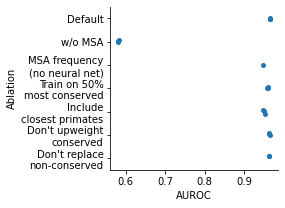

In [13]:
plt.figure(figsize=(3,3))
g = sns.stripplot(
    data=results_clinvar2,
    y="Ablation",
    x="AUROC",
    order=hparam_name.values(),
)
sns.despine()

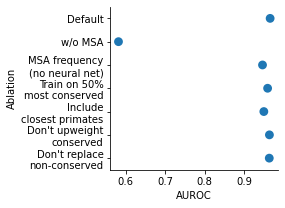

In [14]:
plt.figure(figsize=(3,3))
g = sns.pointplot(
    data=results_clinvar2,
    y="Ablation",
    x="AUROC",
    order=hparam_name.values(),
    join=False,
)
sns.despine()

## gnomAD rare vs. common

In [15]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    #df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    return _compute_odds_ratio(df)

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [16]:
# TODO: should maybe make a lineplot with different thresholds
tq = 1e-3

rows = []
df_c = V[V.source=="gnomAD"]
df_c = df_c[df_c.AC != df_c.AN - 1]
df_c = df_c.dropna(subset=models + ["phyloP", "CADD", "phyloP-Zoonomia", "phastCons"])
for m in tqdm(models):
    subtitle = get_subtitle("All", (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
    OR, p_value, min_counts, cil, ciu = compute_odds_ratio(df_c[[m, "label"]], tq, m)
    rows.append([m, OR, p_value, min_counts, cil, ciu, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "subtitle"])
results_gnomad

100%|██████████| 19/19 [01:03<00:00,  3.34s/it]


,Model,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,38.350315,0.000000e+00,245,33.694110,43.649963,All\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,35.517883,0.000000e+00,264,31.350007,40.239863,All\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,37.105859,0.000000e+00,253,32.666287,42.148800,All\nn=4812825 vs. 4811795
3,multiz100way/89/128/64/True/defined.phastCons....,29.126281,0.000000e+00,320,25.995513,32.634102,All\nn=4812825 vs. 4811795
4,multiz100way/89/128/64/True/defined.phastCons....,29.507696,0.000000e+00,316,26.317691,33.084365,All\nn=4812825 vs. 4811795
5,multiz100way/89/128/64/True/defined.phastCons....,27.437477,0.000000e+00,339,24.564744,30.646163,All\nn=4812825 vs. 4811795
6,multiz100way/99/128/64/True/defined.phastCons....,33.186598,0.000000e+00,282,29.407712,37.451070,All\nn=4812825 vs. 4811795
7,multiz100way/99/128/64/True/defined.phastCons....,31.135069,0.000000e+00,300,27.688438,35.010733,All\nn=4812825 vs. 4811795
8,multiz100way/99/128/64/True/defined.phastCons....,30.300248,0.000000e+00,308,26.986043,34.021476,All\nn=4812825 vs. 4811795
9,multiz100way/89/128/64/True/defined.phastCons....,1.965133,8.415171e-228,3247,1.882167,2.051756,All\nn=4812825 vs. 4811795


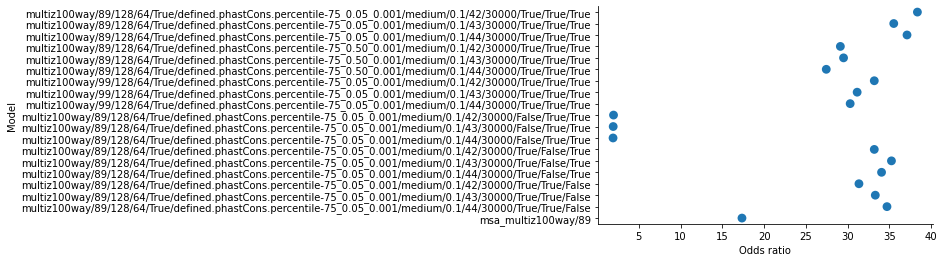

In [17]:
sns.pointplot(data=results_gnomad, y="Model", x="Odds ratio", join=False)
sns.despine();

In [18]:
results_gnomad["Ablation"] = None
for k, v in hparam_name.items():
    results_gnomad.loc[results_gnomad.Model.str.match(k), "Ablation"] = v
results_gnomad2 = results_gnomad.dropna()
results_gnomad2.Ablation.value_counts()

Ablation
Default                           3
Train on 50%\nmost conserved      3
Include\nclosest primates         3
w/o MSA                           3
Don't upweight\nconserved         3
Don't replace\nnon-conserved      3
MSA frequency\n(no neural net)    1
Name: count, dtype: int64

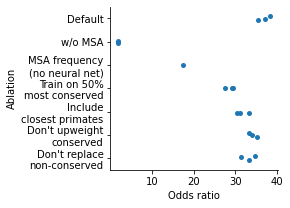

In [19]:
plt.figure(figsize=(3,3))
g = sns.stripplot(
    data=results_gnomad2,
    y="Ablation",
    x="Odds ratio",
    order=hparam_name.values(),
)
sns.despine()

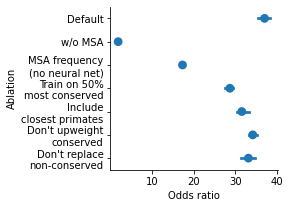

In [20]:
plt.figure(figsize=(3,3))
g = sns.pointplot(
    data=results_gnomad2,
    y="Ablation",
    x="Odds ratio",
    order=hparam_name.values(),
    join=False,
)
sns.despine()

## Merged

In [21]:
merged_res = results_clinvar2.merge(results_gnomad2, how="inner", on=["Model", "Ablation"])
merged_res

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Default,38.350315,0.000000e+00,245,33.694110,43.649963,All\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Default,35.517883,0.000000e+00,264,31.350007,40.239863,All\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Default,37.105859,0.000000e+00,253,32.666287,42.148800,All\nn=4812825 vs. 4811795
3,multiz100way/89/128/64/True/defined.phastCons....,0.960399,0.972493,Train on 50%\nmost conserved,29.126281,0.000000e+00,320,25.995513,32.634102,All\nn=4812825 vs. 4811795
4,multiz100way/89/128/64/True/defined.phastCons....,0.959882,0.972304,Train on 50%\nmost conserved,29.507696,0.000000e+00,316,26.317691,33.084365,All\nn=4812825 vs. 4811795
5,multiz100way/89/128/64/True/defined.phastCons....,0.958839,0.971034,Train on 50%\nmost conserved,27.437477,0.000000e+00,339,24.564744,30.646163,All\nn=4812825 vs. 4811795
6,multiz100way/99/128/64/True/defined.phastCons....,0.950688,0.964791,Include\nclosest primates,33.186598,0.000000e+00,282,29.407712,37.451070,All\nn=4812825 vs. 4811795
7,multiz100way/99/128/64/True/defined.phastCons....,0.947808,0.962989,Include\nclosest primates,31.135069,0.000000e+00,300,27.688438,35.010733,All\nn=4812825 vs. 4811795
8,multiz100way/99/128/64/True/defined.phastCons....,0.951931,0.965355,Include\nclosest primates,30.300248,0.000000e+00,308,26.986043,34.021476,All\nn=4812825 vs. 4811795
9,multiz100way/89/128/64/True/defined.phastCons....,0.580872,0.713468,w/o MSA,1.965133,8.415171e-228,3247,1.882167,2.051756,All\nn=4812825 vs. 4811795


In [22]:
markers = {}
for hparam in hparam_name.values():
    markers[hparam] = 'X' if hparam == "MSA frequency\n(no neural net)" else 'o'

Text(0, 0.5, 'gnomAD odds ratio')

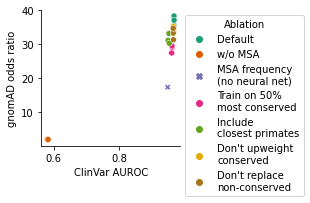

In [23]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("ClinVar AUROC")
plt.ylabel("gnomAD odds ratio")

Text(0, 0.5, 'gnomAD odds ratio')

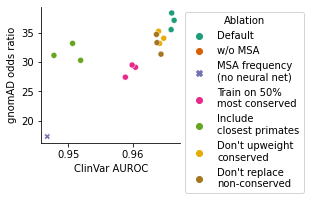

In [24]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res[merged_res.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("ClinVar AUROC")
plt.ylabel("gnomAD odds ratio")

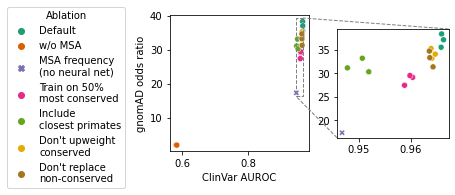

In [26]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(-1.2, 1.1))


#axins = inset_axes(g, width='60%', height='60%', loc='center')

axins = inset_axes(g, 
                   width='100%',  # Width of the inset plot (as a percentage of the main plot)
                   height='100%',  # Height of the inset plot
                   loc='center', 
                   bbox_to_anchor=(1.2, 0.1, 0.8, 0.8),  # (x, y, width, height) relative to the size and position of the main plot
                   bbox_transform=g.transAxes,  # Coordinate system transformation
                   borderpad=0)  # Optional padding around the inset plot


sns.scatterplot(
    data=merged_res[merged_res.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    legend=False,
    ax=axins,
    style="Ablation", markers=markers,
)

# doesn't look good
#x1, x2 = axins.get_xlim()
#y1, y2 = axins.get_ylim()
#axins.set_xlim(x1-1e-2, x2+1e-2)
#axins.set_ylim(y1, y2)

axins.set_xlabel("")
axins.set_ylabel("")
mark_inset(g, axins, loc1=3, loc2=1, fc="none", ec="0.5", linestyle="--")
g.set_xlabel("ClinVar AUROC")
g.set_ylabel("gnomAD odds ratio")
#plt.savefig(plot_dir + "ablation.pdf", bbox_inches="tight")

In [28]:
axins.get_ylim()

(16.268740996682208, 39.281112308413284)

In [29]:
#merged_res_avg = merged_res.groupby("Ablation").agg({"AUROC": "mean", "Odds ratio": "mean"}).reset_index()
#merged_res_avg

In [30]:
"""
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res_avg,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(-1.2, 1.05))


#axins = inset_axes(g, width='60%', height='60%', loc='center')

axins = inset_axes(g, 
                   width='100%',  # Width of the inset plot (as a percentage of the main plot)
                   height='100%',  # Height of the inset plot
                   loc='center', 
                   bbox_to_anchor=(1.2, 0.1, 0.8, 0.8),  # (x, y, width, height) relative to the size and position of the main plot
                   bbox_transform=g.transAxes,  # Coordinate system transformation
                   borderpad=0)  # Optional padding around the inset plot


sns.scatterplot(
    data=merged_res_avg[merged_res_avg.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    legend=False,
    ax=axins,
)
axins.set_xlabel("")
axins.set_ylabel("")
mark_inset(g, axins, loc1=3, loc2=1, fc="none", ec="0.5", linestyle="--")
g.set_xlabel("ClinVar AUROC")
g.set_ylabel("gnomAD odds ratio")
#plt.savefig(plot_dir + "ablation.svg", bbox_inches="tight")
""";